In [1]:
# Familiar imports
import numpy as np
import pandas as pd
import random
import os
import time
from pathlib import Path
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from scipy.optimize import minimize

#import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 17
    CVSEED = 17
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 10000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 17
    CVSEED = 17
    #N_ITERS = 10

In [3]:
def set_seed(seed=17):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Load data

In [4]:
# Load the training data
train = pd.read_csv("../input/30-days-of-ml/train.csv")
test = pd.read_csv("../input/30-days-of-ml/test.csv")
submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# Preview the data
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [5]:
train['lgbl2_pred'] = np.load("../input/30d-lgb-lv2-pred/2lgb_oof.npy")+ np.load("../input/30d-lgb-lv2-pred/3lgb_oof.npy")+ np.load("../input/30d-lgb-lv2-pred/4lgb_oof.npy")
test['lgbl2_pred'] = np.load("../input/30d-lgb-lv2-pred/2lgb_pred.npy")+ np.load("../input/30d-lgb-lv2-pred/3lgb_pred.npy")+ np.load("../input/30d-lgb-lv2-pred/4lgb_pred.npy")

train['lgb_pred'] = np.load("../input/30d-ml-2021-stacking-lgb/lgb_oof.npy")
test['lgb_pred'] = np.load("../input/30d-ml-2021-stacking-lgb/lgb_pred.npy")

train['rr_pred'] = np.load("../input/30d-stacking-rf-pred/2rr_oof.npy")+np.load("../input/30d-stacking-rf-pred/3rr_oof.npy")+np.load("../input/30d-stacking-rf-pred/4rr_oof.npy")
test['rr_pred'] = np.load("../input/30d-stacking-rf-pred/2rr_pred.npy")+np.load("../input/30d-stacking-rf-pred/3rr_pred.npy")+np.load("../input/30d-stacking-rf-pred/4rr_pred.npy")


In [6]:
# Separate target from features
y = train['target']
features = train.drop(['id','target'], axis=1)

# Preview features
features.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,lgbl2_pred,lgb_pred,rr_pred
0,B,B,B,C,B,B,A,E,C,N,...,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.436433,8.447180,8.445473
1,B,B,A,A,B,D,A,F,A,O,...,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.356099,8.379196,8.367401
2,A,A,A,C,B,D,A,D,A,F,...,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.209022,8.243932,8.242520
3,B,B,A,C,B,D,A,E,C,K,...,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.390101,8.404801,8.411158
4,A,A,A,C,B,D,A,E,A,N,...,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,8.207458,8.237940,8.236186


# Preprocessing

In [7]:

# List of categorical columns
object_cols = [col for col in features.columns if 'cat' in col]

# ordinal-encode categorical columns
X = features.copy()
X_test = test.drop(['id'], axis=1).copy()
ordinal_encoder = OrdinalEncoder()
X[object_cols] = ordinal_encoder.fit_transform(features[object_cols])
X_test[object_cols] = ordinal_encoder.transform(test[object_cols])

# Preview the ordinal-encoded features
X.head()


,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,lgbl2_pred,lgb_pred,rr_pred
0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,13.0,...,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.436433,8.447180,8.445473
1,1.0,1.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,14.0,...,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.356099,8.379196,8.367401
2,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,5.0,...,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.209022,8.243932,8.242520
3,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,2.0,10.0,...,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.390101,8.404801,8.411158
4,0.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0,...,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,8.207458,8.237940,8.236186


In [8]:
'''
# List of categorical columns
object_cols = [col for col in features.columns if 'cat' in col]

# one-hot-encode categorical columns
X = features.copy()
X_test = test.drop(['id'], axis=1).copy()

oh_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
X_ohe = oh_encoder.fit_transform(features[object_cols])
X_test_ohe = oh_encoder.transform(test[object_cols])

X_ohe = pd.DataFrame(X_ohe, columns=[f"ohe_{i}" for i in range(X_ohe.shape[1])])
X_test_ohe = pd.DataFrame(X_test_ohe, columns=[f"ohe_{i}" for i in range(X_test_ohe.shape[1])])

X = pd.concat([X, X_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1)
X = X.drop(object_cols, axis=1)
X_test = X_test.drop(object_cols, axis=1)
    
# Preview the one-hot-encoded features
X.head()
'''

'\n# List of categorical columns\nobject_cols = [col for col in features.columns if \'cat\' in col]\n\n# one-hot-encode categorical columns\nX = features.copy()\nX_test = test.drop([\'id\'], axis=1).copy()\n\noh_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")\nX_ohe = oh_encoder.fit_transform(features[object_cols])\nX_test_ohe = oh_encoder.transform(test[object_cols])\n\nX_ohe = pd.DataFrame(X_ohe, columns=[f"ohe_{i}" for i in range(X_ohe.shape[1])])\nX_test_ohe = pd.DataFrame(X_test_ohe, columns=[f"ohe_{i}" for i in range(X_test_ohe.shape[1])])\n\nX = pd.concat([X, X_ohe], axis=1)\nX_test = pd.concat([X_test, X_test_ohe], axis=1)\nX = X.drop(object_cols, axis=1)\nX_test = X_test.drop(object_cols, axis=1)\n    \n# Preview the one-hot-encoded features\nX.head()\n'

In [9]:
scale_features = [col for col in features.columns if 'pred' in col]

ss = StandardScaler()
X[scale_features] = ss.fit_transform(features[scale_features])
X_test[scale_features] = ss.transform(test[scale_features])

In [10]:
# Swap noise

# Random
def apply_noise_rn(df, p=.75):
    should_not_swap = np.random.binomial(1, p, df.shape)
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Row-wise
def apply_noise_row(df, p=.75):
    should_not_swap = np.zeros(df.shape)
    for i in range(df.shape[0]):
        for j in np.random.choice(df.shape[1],int(p*df.shape[1]),replace=False):
            should_not_swap[i,j]=1 
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Pseudo Label

In [11]:
pseudo = pd.read_csv("../input/competition-part-6-stacking/submission.csv")[target]
train_pseudo = pd.concat([X, y], axis=1)
test_pseudo = pd.concat([X_test, pseudo], axis=1)
all_pseudo = pd.concat([train_pseudo, test_pseudo]).reset_index(drop=True)

# EN

In [12]:
en_params = {
               'max_iter':N_ESTIMATORS,
    
                'alpha': 0.01007142705729236, 
                'l1_ratio': 0.016602494998331628,
                'selection': 'cyclic'
        
}

In [13]:
en_oof = np.zeros(train.shape[0])
en_pred = np.zeros(test.shape[0])
en_importances = pd.DataFrame()

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED, SEED+1, SEED+2]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=all_pseudo[scale_features], y=all_pseudo[target])):
    print(f"===== fold {fold} =====")
    if fold < 15:
    
        oof_idx = np.array([idx for idx in val_idx if idx < train.shape[0]])
        preds_idx = np.array([idx for idx in val_idx if idx >= train.shape[0]])

        X_train, y_train = all_pseudo[scale_features].iloc[trn_idx], all_pseudo[target].iloc[trn_idx]
        #X_train = apply_noise_row(X_train)

        X_valid, y_valid = all_pseudo[scale_features].iloc[oof_idx], all_pseudo[target].iloc[oof_idx]
        X_test = all_pseudo[scale_features].iloc[preds_idx]

        # en
        start = time.time()

        for inseed in seed_list:
            en_params2 = en_params.copy()
            en_params2['random_state'] = inseed

            model = ElasticNet(**en_params2, warm_start=True)
            model.fit(
                X_train, 
                y_train,

            )

            #en_params2['reg_lambda'] *= 0.9
            en_params2['alpha'] *= 0.9
            #en_params2['learning_rate'] *= 0.1
            #model = ElasticNet(**en_params2, warm_start=True)
            model.fit(
                    X_train, y_train,

            )    

           

            with open(f"en_model{fold}.pkl", 'wb') as f:
                pickle.dump(model, f)

            

            en_oof[oof_idx] += model.predict(X_valid) / len(seed_list)
            en_pred[preds_idx-train.shape[0]] += model.predict(X_test) / len(seed_list)
            model = None

        elapsed = time.time() - start
        rmse = mean_squared_error(y_valid, en_oof[oof_idx], squared=False)
        print(f"fold {fold} - en rmse: {rmse:.6f}, elapsed time: {elapsed:.2f}sec\n")

        
print(f"oof en_rmse = {mean_squared_error(train[target], en_oof, squared=False)}")

np.save("en_oof.npy", en_oof)
np.save("en_pred.npy", en_pred)

===== fold 0 =====
fold 0 - en rmse: 0.708910, elapsed time: 1.83sec

===== fold 1 =====
fold 1 - en rmse: 0.707454, elapsed time: 1.75sec

===== fold 2 =====
fold 2 - en rmse: 0.713522, elapsed time: 1.65sec

===== fold 3 =====
fold 3 - en rmse: 0.715954, elapsed time: 1.65sec

===== fold 4 =====
fold 4 - en rmse: 0.716166, elapsed time: 1.73sec

===== fold 5 =====
fold 5 - en rmse: 0.720567, elapsed time: 1.71sec

===== fold 6 =====
fold 6 - en rmse: 0.716965, elapsed time: 1.82sec

===== fold 7 =====
fold 7 - en rmse: 0.713212, elapsed time: 1.68sec

===== fold 8 =====
fold 8 - en rmse: 0.714479, elapsed time: 1.87sec

===== fold 9 =====
fold 9 - en rmse: 0.716977, elapsed time: 1.71sec

oof en_rmse = 0.7144280120248894


# OOF predictions

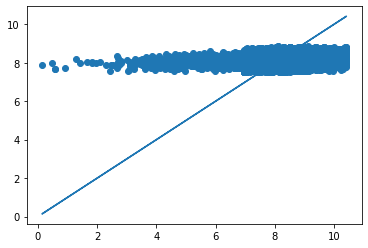

In [14]:
plt.plot(train[target], train[target])
plt.scatter(train[target], en_oof)

# Submission

In [15]:
submission[target] = en_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,0,8.063671
1,5,8.413587
2,15,8.423649
3,16,8.489109
4,17,8.137692
...,...,...
199995,499987,8.017862
199996,499990,8.477469
199997,499991,8.530822
199998,499994,8.205487
